# Monte Carlo Markov Chains para Cosmic Shear

Agora que vimos os conceitos básicos de MCMC e análise estatística, é a sua vez. A Gabriela gerou dados observacionais de lenteamento gravitacional fraco de galáxias, enquanto o Guilherme explicou como fornecer previsões teóricas. O objetivo é obter intervalos de confiança para dois parâmetros cosmológicos, $\Omega_m$ e $\sigma_8$, e gerar um corner plot para ambos.

Vou deixar vocês com um código base, copiado da Gabriela e do Guilherme.

Me chamem se tiverem qualquer dúvida ou problema!

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from classy import Class

In [ ]:
dv = np.load("data/cl_kkgal_input.npy")
ells = np.arange(len(dv))
zz, nz = np.load("data/dndz_input_z3_lensing_field_lsstlike.npy")
np.savetxt("data/dndz_class.txt", np.stack((zz, nz), axis=1))

In [ ]:


def get_cl_kk(Omega_m, sigma_8):
    lmax = 2200
    params = {
        # Saídas necessárias (CMB + LSS)
        'modes': 's',
        'output': 'tCl, pCl, lCl, mPk, nCl, sCl',
        'lensing': 'yes',
        'l_max_scalars': lmax,
        'l_max_lss': lmax,
        'number_count_contributions': 'density',

        # Energia escura via fld
        'Omega_Lambda': 0,
        'w0_fld': '-1.',
        'wa_fld': '0.0',

        # Espectro primordial (n_s fixo; sigma8 varia no loop)
        'n_s': 0.96,

        # Verbosidade e gauge
        'background_verbose': 0,
        'perturbations_verbose': 0,
        'gauge': 'Synchronous',

        # P(k) linear
        'z_pk': '1.0, 0.0',
        'P_k_max_h/Mpc': 10,
        'k_per_decade_for_pk': 30,
        'non linear': 'halofit',

        # Fundo
        'h': 0.673,
        'Omega_b': 0.05,

        'dNdz_selection': 'data/dndz_class.txt',

        'N_ncdm': 1,
        'm_ncdm': 0.06,
        'T_ncdm': 0.7137658555036082,
        'N_ur': 2.046,
    }
    Omega_nu_fid = 0.06/93.15/params['h']**2
    params.update({
        'Omega_cdm': Omega_m - params['Omega_b']  - Omega_nu_fid,
        'sigma8': sigma_8,
    })
    
    cosmo = Class()
    cosmo.set(params)
    cosmo.compute()
    
    cl = cosmo.density_cl(lmax)
    Cl_kk  = np.asarray(cl['ll']['lens[1]-lens[1]'])
    ell = np.arange(len(Cl_kk))

    return ell, np.asarray(Cl_kk)

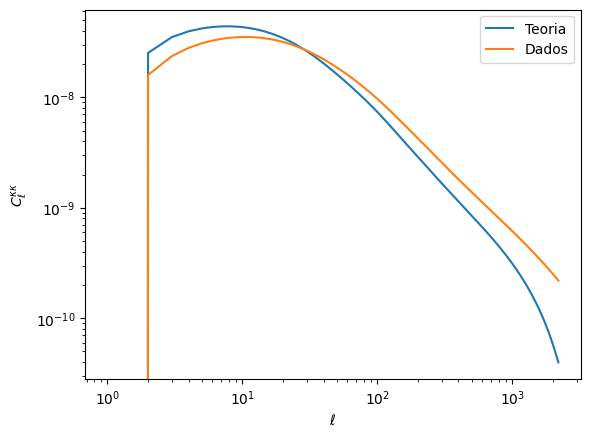

In [8]:
# Exemplo de cosmologia
ell, cl_kk, _ = get_cl_kk(Omega_m=0.3, sigma_8=0.820)
fac = (ell**4 + 2*ell**3 - ell*2 - 2*ell)/4
plt.loglog(ell, fac*cl_kk, label="Teoria")
plt.loglog(ells, dv,        label="Dados")
plt.legend()
plt.xlabel("$\\ell$")
plt.ylabel("$C_\\ell^{\\kappa\\kappa}$")
plt.savefig("comparacao_cl_kk.pdf")